# Programming Assignment 4
## Neural Networks

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Utility Functions

## Metrics

In [195]:
def accuracy(y_true, y_pred):

    if(len(y_true.shape) == 1):
        y_true = y_true.reshape(-1, 1)
    if(len(y_pred.shape) == 1):
        y_pred = y_pred.reshape(-1, 1)

    right_prediction = y_true == y_pred
    try:
        right_prediction = np.all(right_prediction, axis=1)
    except Exception as e:
        print(right_prediction)
        raise
    accuracy = right_prediction.sum() / len(y_true)
    return accuracy


def recall(y_true, y_pred):
    if(len(y_true.shape) == 1):
        y_true = y_true.reshape(-1, 1)
    if(len(y_pred.shape) == 1):
        y_pred = y_pred.reshape(-1, 1)
        
    array = np.hstack([y_true, y_pred])
    array = array[array[:,0] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    recall = right_prediction.sum() / len(array)
    return recall

def precision(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,1] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    precision = right_prediction.sum() / len(array)

    return precision

def f1_score(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)

    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

def binary_cross_entropy_loss(y, y_pred_proba):
    cost_1 = y.T @ np.log(y_pred_proba)
    cost_0 = (1-y).T @ np.log(1-y_pred_proba)
    j = -(1/len(y)) * (cost_1 + cost_0)
    return j.ravel()[0]

def cross_entropy_loss(y_true, y_pred_proba):
    return -np.sum(y_true * np.log(y_pred_proba)) / y_true.shape[0]

def mse(y_true, y_pred):
    
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    return np.mean((y_true - y_pred)**2)

def get_rmse(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.sqrt(mse(y_true, y_pred))

def get_mae(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean(np.abs(y_true - y_pred))

def get_mre(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    return np.mean(np.abs((y_true - y_pred)/y_true))

In [18]:
import pandas as pd

def get_regression_metrics(y_true, y_pred, index=''):
    return pd.DataFrame([
        {
            'MSE': mse(y_true, y_pred),
            'RMSE': get_rmse(y_true, y_pred),
            'MAE': get_mae(y_true, y_pred),
            'MRE': get_mre(y_true, y_pred)
        }
    ], index=[index])

def get_classification_metrics(y_true, y_pred, index=''):
    return pd.DataFrame([
        {
            'Accuracy': accuracy(y_true, y_pred)
        }
    ], index=[index])


## MinMaxScaler

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

## Standardization


In [5]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Cross Validation

In [6]:
def get_cv_folds(data, n_folds=10, shuffle=True, random_state=12894):
    indexes = np.arange(data.shape[0])
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indexes)

    slices = np.array_split(indexes, n_folds)
    all_elements = np.hstack(slices)   
    
    splits = []
    for i in range(n_folds):
        train_idx = all_elements[~np.isin(all_elements, slices[i])]
        test_idx = slices[i]

        splits.append((train_idx, test_idx))

    return splits

## Train Test Split

In [7]:
def train_test_split(X, y, train_size_perc, random_seed=264852):
    
    y = y.reshape(-1, 1)
    
    N = X.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    X_train = X[train_idx, :]
    y_train = y[train_idx, :]
    X_test = X[test_idx, :]
    y_test = y[test_idx, :]

    return X_train, X_test, y_train, y_test


## Do Cross Validation and Get Metrics

In [8]:
def do_cv_and_get_metrics(classifier, cv_splits, X_train, y_train, X_test, title='Classifier', scaler=None):

    X_train = X_train.copy()
    y_train = y_train.copy()
    X_test = X_test.copy()

    train_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }

    valid_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }
    # Reporting results
    print('#' + f'{title}'.center(60, '-') + '#')

    print('\n---> Validation Folds Metrics')
    print('Fold\tAccuracy\tRecall\t\tPrecision\tF1-Score')
    count_fold = 1
    for train_idx, val_idx in cv_splits:
        # Spliting data
        X_train_cv = X_train[train_idx, :]
        y_train_cv = y_train[train_idx, :]
        X_val_cv = X_train[val_idx, :]
        y_val_cv = y_train[val_idx, :]

        # Scaling if have scaler argument
        if scaler is not None:
            X_train_cv = scaler.fit_transform(X_train_cv)
            X_val_cv = scaler.transform(X_val_cv)

        # Training Model
        classifier.fit(X_train_cv, y_train_cv.ravel())

        # Predictions
        y_train_cv_pred = classifier.predict(X_train_cv)
        y_val_cv_pred = classifier.predict(X_val_cv)

        # Storing metrics
        train_metrics['accuracy'].append(accuracy(y_train_cv, y_train_cv_pred))
        train_metrics['recall'].append(recall(y_train_cv, y_train_cv_pred))
        train_metrics['precision'].append(precision(y_train_cv, y_train_cv_pred))
        train_metrics['f1_score'].append(f1_score(y_train_cv, y_train_cv_pred))

        valid_metrics['accuracy'].append(accuracy(y_val_cv, y_val_cv_pred))
        valid_metrics['recall'].append(recall(y_val_cv, y_val_cv_pred))
        valid_metrics['precision'].append(precision(y_val_cv, y_val_cv_pred))
        valid_metrics['f1_score'].append(f1_score(y_val_cv, y_val_cv_pred))

        print('{0:.0f}\t{1:.4f}  \t{2:.4f}\t\t{3:.4f}   \t{4:.4f}'.format(
                count_fold,
                valid_metrics['accuracy'][-1], 
                valid_metrics['recall'][-1],
                valid_metrics['precision'][-1],
                valid_metrics['f1_score'][-1]
            )
        )
        count_fold+=1


    print('\n--->\tTraining Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['accuracy']), 
        np.std(train_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(train_metrics['recall']), 
        np.std(train_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['precision']), 
        np.std(train_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['f1_score']), 
        np.std(train_metrics['f1_score']))
    )

    print('\n--->\tValidation Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['accuracy']), 
        np.std(valid_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(valid_metrics['recall']), 
        np.std(valid_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['precision']), 
        np.std(valid_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['f1_score']), 
        np.std(valid_metrics['f1_score']))
    )

    print('\n--->\tTest Metrics')

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.ravel())
    y_test_pred = classifier.predict(X_test)

    print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
    print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
    print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
    print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))


## Activation Functions 

In [9]:
class Sigmoid():
    @staticmethod
    def get_value(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def get_derivative(x):
        return Sigmoid.get_value(x) - Sigmoid.get_value(x)**2

class TanH:
    @staticmethod
    def get_value(x):
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)

    @staticmethod
    def get_derivative(x):
        return 1 - TanH().get_value(x) ** 2

class ReLU():
    @staticmethod
    def get_value(x):
        return np.maximum(0, x)

    @staticmethod
    def get_derivative(x):
        return np.where(x <= 0, 0, 1)

class Identity():
    @staticmethod
    def get_value(x):
        return np.ones(x.shape) * x

    @staticmethod
    def get_derivative(x):
        return np.ones(x.shape)



# MLP Implementation (Regression and Classification)

In [204]:
class MyMLP():

    def __init__(self, loss_function, output_activation_function, verbose=False):
        self.fitted = False
        self.n_hidden = []
        self.activation_functions = [Identity(), output_activation_function]
        self.verbose=verbose
        self.best_epoch = None
        self.loss_function = loss_function
        
        
    def add_hidden_layer(self, n_neurons, activation_function):
        self.n_hidden.append(n_neurons)
        self.activation_functions = self.activation_functions[:-1] \
            + [activation_function] \
            + [self.activation_functions[-1]]


    def initialize_weights(self, X, y, random_state=None):
        self.weights = []
        self.last_gradient = []

        if random_state is None:
            seed = np.random.RandomState()
        else:
            seed = np.random.RandomState(random_state)

        self.layers = [X.shape[1]] + self.n_hidden + [y.shape[1]]
        
        for i in range(len(self.layers)-1):
            # Initialization strategies
            if type(self.activation_functions[i]) == ReLU:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(2/self.layers[i+1])  
                w = np.hstack([np.ones((self.layers[i+1], 1))*0.1, w])
            else:
                w = seed.normal(
                    size = (self.layers[i+1], self.layers[i])
                ) * np.sqrt(1/self.layers[i+1])
                w = np.hstack([np.zeros((self.layers[i+1], 1)), w])               

            self.weights.append(w)
            self.last_gradient.append(None)

        self.momentum_weights = [np.zeros_like(w) for w in self.weights]


    def forward_propagation(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        self.layer_inputs = []
        self.layer_outputs = []

        self.layer_inputs.append(input)
        self.layer_outputs.append(input)
        
        # Calculating input of next layer
        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            self.layer_inputs.append(input)

            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            self.layer_outputs.append(activated_output)
            input = activated_output

        return activated_output # Output


    def back_propagation(self, error, learning_rate, momentum_factor=0):
        output_layer = True
        self.deltas = []
        
        # Calculates deltas
        for i in range(len(self.activation_functions)-1, 0, -1):
            act_function = self.activation_functions[i]
            
            if output_layer:
                layer_outputs = self.layer_outputs[i]
                delta_i = error * act_function.get_derivative(layer_outputs)
                self.deltas = [delta_i] + self.deltas
                output_layer=False
            else:
                layer_outputs = self.layer_outputs[i][:, 1:]
                weights = self.weights[i][:, 1:]
                delta_i = act_function.get_derivative(layer_outputs) \
                    * (self.deltas[0] @ weights)
                self.deltas = [delta_i] + self.deltas

        # Update weights
        for i in range(len(self.weights)):
            gradient = (self.deltas[i].T @ self.layer_outputs[i]) / len(error)
            update_factor = (learning_rate * gradient) + (momentum_factor * self.momentum_weights[i])
            self.weights[i] -= update_factor
            self.momentum_weights[i] = update_factor
            

    def get_minibatches(self, X, y, batch_size):
        init_index=0
        batches = []

        for final_index in range(batch_size, X.shape[0]+batch_size, batch_size):
            
            X_minibatch = X[init_index:final_index]
            y_minibatch = y[init_index:final_index]

            init_index = final_index
            batches.append((X_minibatch, y_minibatch))
        
        return batches


    def fit(
        self, 
        X, 
        y, 
        learning_rate=0.1,
        early_stopping_rounds=None,
        valid_set=None, 
        epochs=100, 
        batch_size=32, 
        momentum_factor=0,
        random_state=None,
        random_state_shuffle=None,
        **kwargs
    ):
        
        self.initialize_weights(X, y, random_state)
        
        self.loss_function_curve = []
        self.loss_function_curve_val = []

        train_indexes = np.arange(X.shape[0], dtype=int)

        # Initializing early stopping variables
        if early_stopping_rounds is not None:
            count_early_stopping = 0
            best_mse = np.inf

        # Training model
        for i, epochs in enumerate(range(epochs)):
            loss_function = 0
            val_loss_function = 0

            seed = np.random.RandomState(random_state_shuffle)
            seed.shuffle(train_indexes) # inplace
            X = X[train_indexes]
            y = y[train_indexes]
            
            batches = self.get_minibatches(X, y, batch_size)
            
            # Iterating through the minibatches
            for j, (input, output) in enumerate(batches):
                y_pred = self.forward_propagation(input)
                    
                error = y_pred - output

                self.back_propagation(
                    error=error, 
                    learning_rate=learning_rate,
                    momentum_factor=momentum_factor
                )

                if valid_set is not None:
                    X_val_it, y_val_it = valid_set[0], valid_set[1]
                    y_val_pred = self.predict_proba(X_val_it)
                    val_iteration_metric = self.loss_function(y_val_it, y_val_pred)

                    # Multiplying by the number of records to weight the 
                    # mse mean at the end of the epoch
                    val_loss_function+=val_iteration_metric
                            

                # Multiplying by the number of records to weight the 
                # mse mean at the end of the epoch
                loss_function+=self.loss_function(output, y_pred)*input.shape[0]            
            
            self.loss_function_curve.append(loss_function/X.shape[0])

            if valid_set is not None:
                loss_valid_epoch = val_loss_function/len(batches)
                self.loss_function_curve_val.append(loss_valid_epoch)
                if self.verbose:
                    if i % self.verbose == 0:
                        print('Epoch {:>4} -> Loss Function: Train {:.6f} | \
Valid {:.6f}'.format(
                                i,
                                loss_function/X.shape[0],
                                loss_valid_epoch
                            )
                        )
            else:
                if self.verbose:
                    if i % self.verbose == 0:
                        print(
                            f'Epoch {i} | Loss Function: ', 
                            loss_function/X.shape[0]
                        )
                    
            if early_stopping_rounds is not None:
                if val_loss_function/X.shape[0] <= best_mse:
                    best_mse = val_loss_function/X.shape[0]
                    best_weights = self.weights
                    self.best_epoch = i
                    count_early_stopping = 0
                else:
                    count_early_stopping += 1

                    if count_early_stopping >= early_stopping_rounds:
                        try:
                            self.weights = best_weights
                            print('\n')
                            print('Early stopping has been activated!')
                            print(f'Best epoch: {self.best_epoch} | \
Validation Loss Function: {best_mse}')
                            print('The model has been reverted to this epoch')
                            print('\n')
                            break
                        except UnboundLocalError as error:
                            print('Convergence error. Ignoring this trial.')
                            break


    def plot_learning_curve(self):
        plt.figure(figsize=(14, 8))
        plt.plot(self.loss_function_curve, label='Train')

        if len(self.loss_function_curve_val)>0:
            plt.plot(self.loss_function_curve_val, label='Validation')
        
        if self.best_epoch is not None:
            plt.axvline(
                self.best_epoch, 
                linestyle='--', 
                color='green', 
                label='Best epoch'
            )

        plt.title('Learning Curves', fontsize=18)
        plt.legend()


    def predict_proba(self, X):
        input = np.hstack(
            [np.ones((X.shape[0],1)), X]
        )

        for i, w in enumerate(self.weights):
            activation_function = self.activation_functions[i+1]            
            
            # Calculating input of next layer
            output = np.array(input @ w.T)

            # Passing values through the activation function of next layer
            activated_output = activation_function.get_value(output)
            
            if i < len(self.weights)-1:
                activated_output = np.hstack(
                    [np.ones((X.shape[0],1)), activated_output]
                )
            input = activated_output

        return activated_output

    def predict(self, X):
        if type(self.activation_functions[-1]) == type(Sigmoid()):
            
                preds = self.predict_proba(X)
                preds = np.argmax(preds, axis=1)
                preds = preds.astype(int).ravel()
                preds_ohe = np.zeros((preds.size, self.layers[-1]))
                preds_ohe[np.arange(preds.size), preds] = 1
                return preds_ohe
        else:
            return self.predict_proba(X)


# Task 1 - MLP (Regression)

In [85]:
data = np.genfromtxt('../data/concrete.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (1030, 9)


array([[ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1040.  ,  676.  ,
          28.  ,   79.99],
       [ 540.  ,    0.  ,    0.  ,  162.  ,    2.5 , 1055.  ,  676.  ,
          28.  ,   61.89],
       [ 332.5 ,  142.5 ,    0.  ,  228.  ,    0.  ,  932.  ,  594.  ,
         270.  ,   40.27]])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 0.8, random_seed=224852
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 0.75, random_seed=7921
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))
print('X_val:   {} ({}%)'.format(X_val.shape[0], X_val.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 618 (60.0%)
X_test:  206 (20.0%)
X_val:   206 (20.0%)


In [87]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)
X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)

### Selecting Parameters

In [63]:
from itertools import product
import time
import warnings
warnings.filterwarnings('ignore')
import copy

def grid_search(model, params, X, y, valid_set, verbose=True):
    
    start = time.time()
    best_mse = np.inf
    params_combination_list = list(product(*list(params.values())))

    for trial, combination in enumerate(params_combination_list):
        actual_params = {param: key for param, key in zip(list(params.keys()), list(combination))}
        
        if verbose:
            print(f'Running trial {trial+1}/{len(params_combination_list)}')
            print('Parameters:', actual_params)
        
        instance = copy.deepcopy(model)
        
        instance.add_hidden_layer(n_neurons=actual_params['n_neurons'], activation_function=TanH())

        instance.fit(
            X,
            y,
            valid_set=valid_set,
            **actual_params
        )

        # Getting metrics
        X_val, y_val = valid_set
        val_preds =  instance.predict(X_val)
        actual_mse = get_rmse(y_val, val_preds)

        if verbose:
            print('Metric:', actual_mse)

        # Storing if best metric
        if actual_mse < best_mse:
            best_mse = actual_mse
            best_params = actual_params
            if verbose:
                print('New best metric!')

        trial+=1
        print('-'*50)

    end = time.time()
    print('-'*50)
    print('Grid Search Completed in ', round(end - start, 4), 'seconds')
    print('Selected parameters:')
    print(best_params)

    return best_params


# Trying only basic parameters In order not to slow down the training
params = {
    'learning_rate': [0.1, 0.01],
    'momentum_factor': [0.5, 0.9],
    'early_stopping_rounds': [200],
    'n_neurons': [10, 20, 50],
    'epochs': [5000], # Fixed because the early_stopping_rounds was set
    'mini_batch': [32]
}

my_mlp = MyMLP(
    loss_function=mse,
    output_activation_function=Identity(), 
    verbose=False
)

best_params = grid_search(
    my_mlp, 
    params,
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled),
    verbose=True    
)
    


Running trial 1/12
Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 10, 'epochs': 5000, 'mini_batch': 32}


Early stopping has been activated!
Best epoch: 4051 | Validation MSE: 0.006699864140108132
The model has been reverted to this epoch


Metric: 0.08396309318679053
New best metric!
--------------------------------------------------
Running trial 2/12
Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'mini_batch': 32}


Early stopping has been activated!
Best epoch: 2879 | Validation MSE: 0.007844754375121263
The model has been reverted to this epoch


Metric: 0.09278633397880372
--------------------------------------------------
Running trial 3/12
Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 50, 'epochs': 5000, 'mini_batch': 32}
Convergence error. Ignoring this trial.
Metric: nan
----------------------

### Training MLP with Selected Parameters

Epoch    0 -> Loss Function: Train 0.467111 | Valid 0.475007
Epoch  100 -> Loss Function: Train 0.009931 | Valid 0.011407
Epoch  200 -> Loss Function: Train 0.008326 | Valid 0.010033
Epoch  300 -> Loss Function: Train 0.008668 | Valid 0.010384
Epoch  400 -> Loss Function: Train 0.007805 | Valid 0.008896
Epoch  500 -> Loss Function: Train 0.007298 | Valid 0.008734
Epoch  600 -> Loss Function: Train 0.007642 | Valid 0.009155
Epoch  700 -> Loss Function: Train 0.006881 | Valid 0.008275
Epoch  800 -> Loss Function: Train 0.006341 | Valid 0.007975
Epoch  900 -> Loss Function: Train 0.006356 | Valid 0.007757
Epoch 1000 -> Loss Function: Train 0.005870 | Valid 0.007207
Epoch 1100 -> Loss Function: Train 0.006341 | Valid 0.007907
Epoch 1200 -> Loss Function: Train 0.005644 | Valid 0.007392
Epoch 1300 -> Loss Function: Train 0.005587 | Valid 0.007453
Epoch 1400 -> Loss Function: Train 0.005281 | Valid 0.007474
Epoch 1500 -> Loss Function: Train 0.005180 | Valid 0.007186


Early stopping has bee

,MSE,RMSE,MAE,MRE
Training,33.034800,5.747591,4.421081,0.162359
Test,48.090593,6.934738,5.173992,0.165733
Validation,45.571789,6.750688,5.044414,0.168739


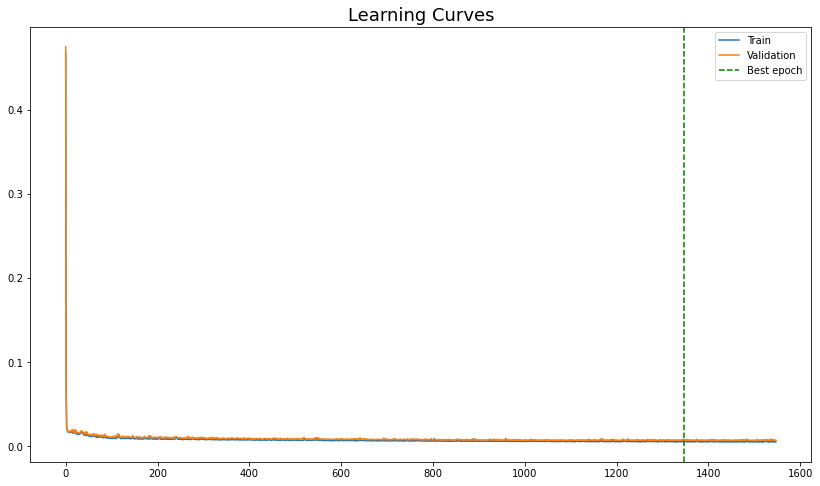

In [65]:
my_mlp = MyMLP(
    loss_function=mse, 
    output_activation_function=Identity(), 
    verbose=100
)

my_mlp.add_hidden_layer(
    n_neurons=best_params['n_neurons'], 
    activation_function=TanH()
)

my_mlp.fit(
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled), 
    **best_params,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

my_mlp.plot_learning_curve()

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])



### Trying more hidden layers

Epoch    0 -> Loss Function: Train 1.953501 | Valid 1.851154
Epoch  100 -> Loss Function: Train 0.010359 | Valid 0.012585
Epoch  200 -> Loss Function: Train 0.009160 | Valid 0.010845
Epoch  300 -> Loss Function: Train 0.008029 | Valid 0.009828
Epoch  400 -> Loss Function: Train 0.008066 | Valid 0.009631
Epoch  500 -> Loss Function: Train 0.007333 | Valid 0.009256
Epoch  600 -> Loss Function: Train 0.007000 | Valid 0.009108
Epoch  700 -> Loss Function: Train 0.006736 | Valid 0.008766
Epoch  800 -> Loss Function: Train 0.006645 | Valid 0.008842
Epoch  900 -> Loss Function: Train 0.006214 | Valid 0.008534
Epoch 1000 -> Loss Function: Train 0.006058 | Valid 0.008514
Epoch 1100 -> Loss Function: Train 0.005861 | Valid 0.008300
Epoch 1200 -> Loss Function: Train 0.005739 | Valid 0.008278
Epoch 1300 -> Loss Function: Train 0.005587 | Valid 0.008222
Epoch 1400 -> Loss Function: Train 0.005512 | Valid 0.008103
Epoch 1500 -> Loss Function: Train 0.005498 | Valid 0.007943
Epoch 1600 -> Loss Funct

,MSE,RMSE,MAE,MRE
Training,26.788367,5.175748,3.928858,0.135490
Test,43.210385,6.573461,4.858194,0.148161
Validation,42.699709,6.534501,4.759200,0.148346


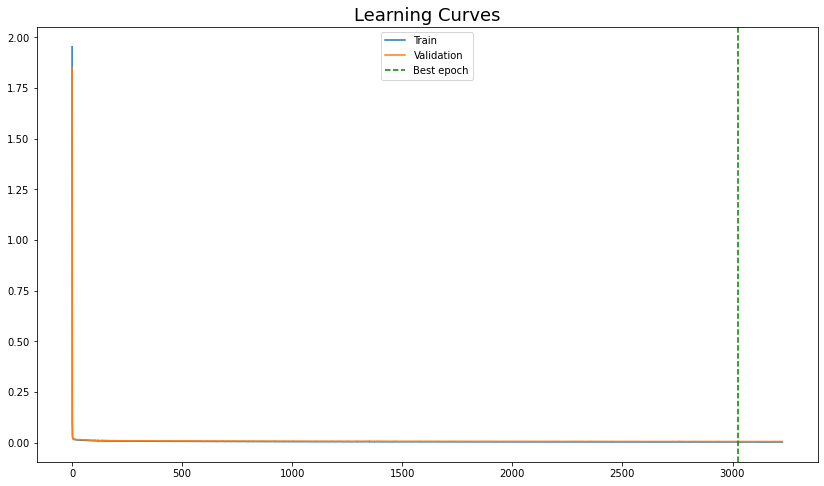

In [74]:
my_mlp = MyMLP(
    loss_function=mse, 
    output_activation_function=Identity(), 
    verbose=100
)

my_mlp.add_hidden_layer(
    n_neurons=50, 
    activation_function=TanH()
)

my_mlp.add_hidden_layer(
    n_neurons=20, 
    activation_function=TanH()
)


my_mlp.fit(
    X=X_train_scaled, 
    y=y_train_scaled, 
    valid_set=(X_val_scaled, y_val_scaled), 
    learning_rate=0.01,
    momentum_factor=0.9,
    early_stopping_rounds=200,
    epochs=5000,
    mini_batch=32,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

my_mlp.plot_learning_curve()

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])



## Testing Keras

In [75]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping

Epoch 1912: early stopping
7/7 [==============================] - 0s 833us/step


,MSE,RMSE,MAE,MRE
Training,44.585489,6.677237,5.554782,0.230161
Test,54.668792,7.393835,5.994693,0.221056
Validation,51.812767,7.198109,5.824082,0.219542


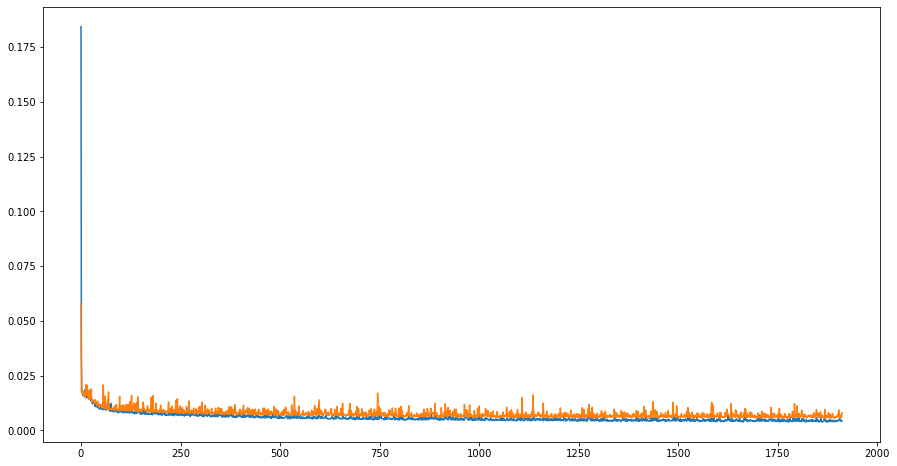

In [79]:
model = Sequential()

model.add(tf.keras.Input(shape=(8,)))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1))

model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=best_params['learning_rate'], 
        momentum=best_params['momentum_factor']), 
    metrics=['mse'])

early_stopping_keras = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=best_params['early_stopping_rounds']

)
history = model.fit(
    X_train_scaled, 
    y_train_scaled, 
    validation_data=(X_val_scaled, y_val_scaled), 
    epochs=best_params['epochs'], 
    batch_size=best_params['mini_batch'], 
    verbose=False, 
    callbacks=[early_stopping_keras]
)

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_val_pred = model.predict(X_val_scaled)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])


## Sklearn MLP

In [77]:
from sklearn.neural_network import MLPRegressor

,MSE,RMSE,MAE,MRE
Training,27.908759,5.282874,4.026361,0.140553
Test,42.983183,6.556156,4.790932,0.145326
Validation,41.498471,6.441931,4.667968,0.149041


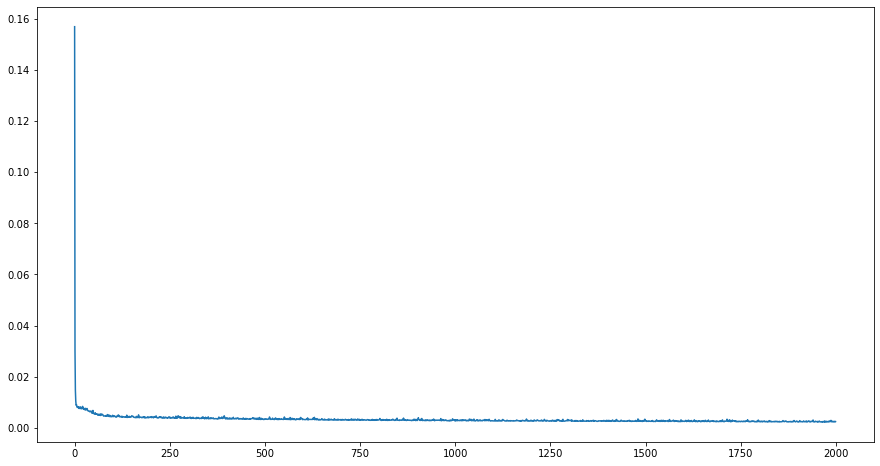

In [88]:
sk_mlp = MLPRegressor(
    hidden_layer_sizes=(10), 
    activation='tanh', 
    solver='sgd',
    batch_size=best_params['mini_batch'], 
    learning_rate="constant",
    shuffle=True,
    power_t=0,
    momentum=best_params['momentum_factor'],
    tol=0.000000001, 
    learning_rate_init=best_params['learning_rate'], 
    validation_fraction=0,
    max_iter=2000,
    n_iter_no_change=9999999,
    alpha=0,
    nesterovs_momentum=False,
    verbose=False,
    random_state=None
)
sk_mlp.fit(X_train_scaled, y_train_scaled.ravel())

plt.figure(figsize=(15,8))
plt.plot(sk_mlp.loss_curve_)

y_train_pred = sk_mlp.predict(X_train_scaled).reshape(-1, 1)
y_test_pred = sk_mlp.predict(X_test_scaled).reshape(-1, 1)
y_val_pred = sk_mlp.predict(X_val_scaled).reshape(-1, 1)

y_train_pred = y_scaler.inverse_transform(y_train_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)
y_val_pred = y_scaler.inverse_transform(y_val_pred)

pd.concat([
    get_regression_metrics(y_train, y_train_pred, index='Training'),
    get_regression_metrics(y_test, y_test_pred, index='Test'),
    get_regression_metrics(y_val, y_val_pred, index='Validation')
])


# Task 2 - MLP (Classification)

In [141]:
data = np.genfromtxt('../data/vowel.csv', delimiter=',')
X = data[:, :-1]
y = data[:, -1]
print('Shape:', data.shape)
data[:3, :]


Shape: (990, 11)


array([[-3.639,  0.418, -0.67 ,  1.779, -0.168,  1.627, -0.388,  0.529,
        -0.874, -0.814,  8.   ],
       [-3.327,  0.496, -0.694,  1.365, -0.265,  1.933, -0.363,  0.51 ,
        -0.621, -0.488,  2.   ],
       [-2.12 ,  0.894, -1.576,  0.147, -0.707,  1.559, -0.579,  0.676,
        -0.809, -0.049,  1.   ]])

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 0.8, random_seed=5474
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 0.75, random_seed=99856
)

print('Number of Rows by Split')
print('X_train: {} ({}%)'.format(X_train.shape[0], X_train.shape[0]/data.shape[0]*100))
print('X_test:  {} ({}%)'.format(X_test.shape[0], X_test.shape[0]/data.shape[0]*100))
print('X_val:   {} ({}%)'.format(X_val.shape[0], X_val.shape[0]/data.shape[0]*100))

Number of Rows by Split
X_train: 594 (60.0%)
X_test:  198 (20.0%)
X_val:   198 (20.0%)


In [143]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

In [144]:
def one_hot_encoding(data):
    data = data.astype(int).ravel()
    data_ohe = np.zeros((data.size, data.max()+1))
    data_ohe[np.arange(data.size), data] = 1
    return data_ohe

y_train = one_hot_encoding(y_train)
y_test = one_hot_encoding(y_test)
y_val = one_hot_encoding(y_val)

print('Training:', y_train.shape)
print('Training:', y_test.shape)
print('Training:', y_val.shape)


Training: (594, 11)
Training: (198, 11)
Training: (198, 11)


## Selecting Parameters

In [224]:
from itertools import product
import time
import warnings
warnings.filterwarnings('ignore')
import copy

def grid_search_classification(model, params, X, y, valid_set, verbose=True):
    
    start = time.time()
    best_metric = -np.inf
    params_combination_list = list(product(*list(params.values())))

    for trial, combination in enumerate(params_combination_list):
        actual_params = {param: key for param, key in zip(
            list(params.keys()), 
            list(combination)
        )}
        
        if verbose:
            print(f'Running trial {trial+1}/{len(params_combination_list)}')
            print('Parameters:', actual_params)
        
        instance = copy.deepcopy(model)
        
        instance.add_hidden_layer(
            n_neurons=actual_params['n_neurons'], 
            activation_function=ReLU()
        )

        instance.fit(
            X,
            y,
            valid_set=valid_set,
            **actual_params
        )

        # Getting metrics
        X_val, y_val = valid_set
        val_preds = instance.predict(X_val)
        actual_metric = accuracy(y_val, val_preds)

        if verbose:
            print('Validation Accuracy:', actual_metric)

        # Storing if best metric
        if actual_metric > best_metric:
            best_metric = actual_metric
            best_params = actual_params
            if verbose:
                print('New best metric!')

        trial+=1
        print('-'*50)

    end = time.time()
    print('-'*50)
    print('Grid Search Completed in ', round(end - start, 4), 'seconds')
    print('Selected parameters:')
    print(best_params)

    return best_params


# Trying only basic parameters in order not to slow down the training
params = {
    'learning_rate': [0.1, 0.01],
    'momentum_factor': [0.5, 0.9],
    'early_stopping_rounds': [200],
    'n_neurons': [20, 50],
    'epochs': [5000], # Fixed because the early_stopping_rounds was set
    'batch_size': [4, 16, 32]
}

my_mlp = MyMLP(
    loss_function=cross_entropy_loss,
    output_activation_function=Sigmoid(), 
    verbose=False
)

best_params = grid_search_classification(
    my_mlp, 
    params,
    X=X_train_scaled, 
    y=y_train, 
    valid_set=(X_val_scaled, y_val),
    verbose=True    
)

Running trial 1/24
Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 4}


Early stopping has been activated!
Best epoch: 755 | Validation Loss Function: 0.13282325730262687
The model has been reverted to this epoch


Validation Accuracy: 0.8232323232323232
New best metric!
--------------------------------------------------
Running trial 2/24
Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 16}


Early stopping has been activated!
Best epoch: 1614 | Validation Loss Function: 0.03142700873181906
The model has been reverted to this epoch


Validation Accuracy: 0.8434343434343434
New best metric!
--------------------------------------------------
Running trial 3/24
Parameters: {'learning_rate': 0.1, 'momentum_factor': 0.5, 'early_stopping_rounds': 200, 'n_neurons': 20, 'epochs': 5000, 'batch_size': 32}


Early stopping 

## Training

Epoch    0 -> Loss Function: Train 2.232239 | Valid 2.246254
Epoch    1 -> Loss Function: Train 2.167297 | Valid 2.197322
Epoch    2 -> Loss Function: Train 2.002231 | Valid 2.009074
Epoch    3 -> Loss Function: Train 1.855566 | Valid 1.856080
Epoch    4 -> Loss Function: Train 1.756677 | Valid 1.749645
Epoch    5 -> Loss Function: Train 1.667926 | Valid 1.636370
Epoch    6 -> Loss Function: Train 1.614029 | Valid 1.591148
Epoch    7 -> Loss Function: Train 1.563473 | Valid 1.536383
Epoch    8 -> Loss Function: Train 1.520907 | Valid 1.494500
Epoch    9 -> Loss Function: Train 1.481666 | Valid 1.462601
Epoch   10 -> Loss Function: Train 1.454834 | Valid 1.421890
Epoch   11 -> Loss Function: Train 1.431469 | Valid 1.384932
Epoch   12 -> Loss Function: Train 1.400742 | Valid 1.376648
Epoch   13 -> Loss Function: Train 1.376069 | Valid 1.362986
Epoch   14 -> Loss Function: Train 1.360768 | Valid 1.316988
Epoch   15 -> Loss Function: Train 1.310480 | Valid 1.297679
Epoch   16 -> Loss Funct

,Accuracy
Training,0.994949
Test,0.919192
Validation,0.893939


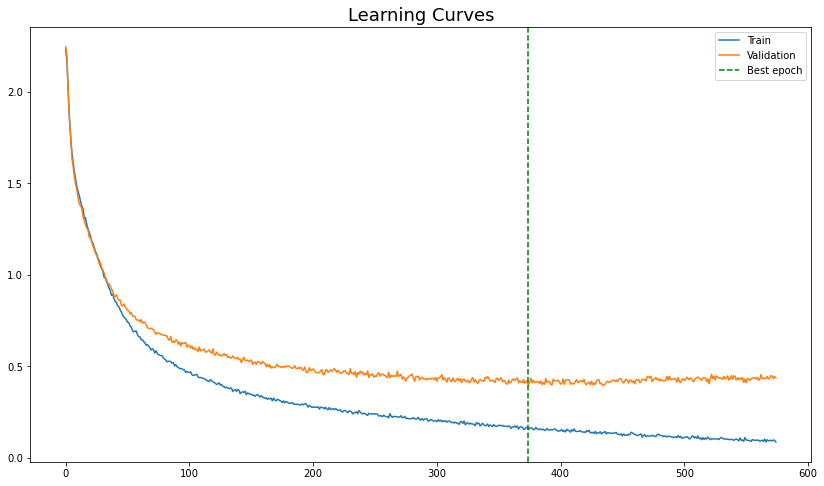

In [225]:
my_mlp = MyMLP(
    loss_function=cross_entropy_loss,
    output_activation_function=Sigmoid(), 
    verbose=True
)
my_mlp.add_hidden_layer(n_neurons=best_params['n_neurons'], activation_function=ReLU())
my_mlp.fit(
    X=X_train_scaled, 
    y=y_train,
    valid_set=(X_val_scaled, y_val), 
    **best_params,
    # epochs=500,
    random_state=None,
    random_state_shuffle=None
)

y_train_pred = my_mlp.predict(X_train_scaled)
y_test_pred = my_mlp.predict(X_test_scaled)
y_val_pred = my_mlp.predict(X_val_scaled)

my_mlp.plot_learning_curve()
pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])



## Keras

In [226]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [227]:
best_params

{'learning_rate': 0.1,
 'momentum_factor': 0.5,
 'early_stopping_rounds': 200,
 'n_neurons': 50,
 'epochs': 5000,
 'batch_size': 4}

In [230]:
model.predict(X_train_scaled)

19/19 [==============================] - 0s 1ms/step


array([[3.41542512e-01, 2.01390356e-01, 1.60642480e-03, ...,
        8.45897841e-09, 4.39110792e-08, 6.80177028e-15],
       [6.20273016e-02, 1.68635231e-02, 2.96172756e-03, ...,
        4.23566071e-10, 8.70472334e-08, 4.92684933e-07],
       [7.45876110e-04, 7.19251048e-10, 4.91322577e-03, ...,
        1.33594836e-13, 5.21709584e-03, 2.04257249e-12],
       ...,
       [1.10146614e-10, 4.36611841e-20, 3.86669446e-11, ...,
        2.26399284e-17, 1.69459768e-02, 1.21301814e-11],
       [9.31541955e-10, 3.28441763e-16, 5.09236987e-14, ...,
        6.06164966e-13, 5.44020906e-03, 9.99529004e-01],
       [2.46286302e-09, 1.26633374e-15, 1.27186508e-11, ...,
        5.60254400e-15, 3.49135860e-03, 8.17833066e-01]], dtype=float32)

Epoch 2515: early stopping
7/7 [==============================] - 0s 1000us/step


,Accuracy
Training,0.0
Test,0.0
Validation,0.0


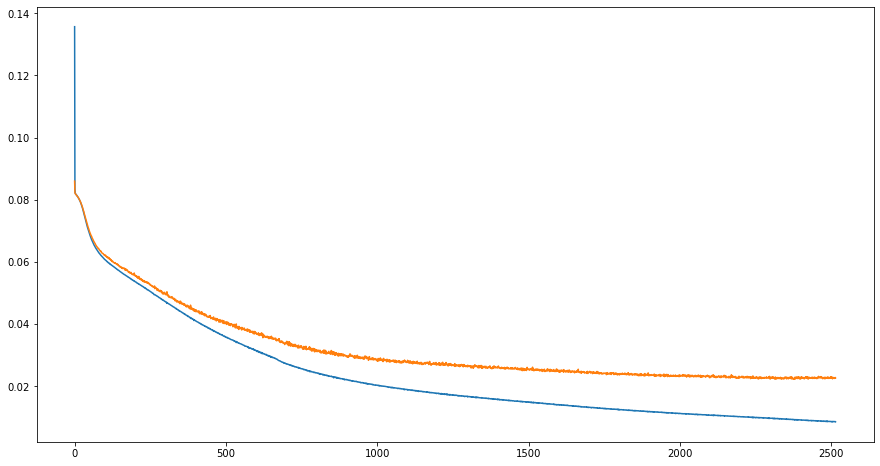

In [229]:
model = Sequential()

model.add(tf.keras.Input(shape=(10,)))
model.add(Dense(best_params['n_neurons'], activation='relu'))
model.add(Dense(11, activation='sigmoid'))

model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=best_params['learning_rate'], 
        momentum=best_params['momentum_factor']), 
    metrics=['mse'])

early_stopping_keras = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=best_params['early_stopping_rounds']
)
history = model.fit(
    X_train_scaled, 
    y_train, 
    validation_data=(X_val_scaled, y_val), 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    verbose=False, 
    callbacks=[early_stopping_keras]
)

plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_val_pred = model.predict(X_val_scaled)



pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])



## Sklearn

In [25]:
from sklearn.neural_network import MLPClassifier

,Accuracy
Training,0.998316
Test,0.823232
Validation,0.797980


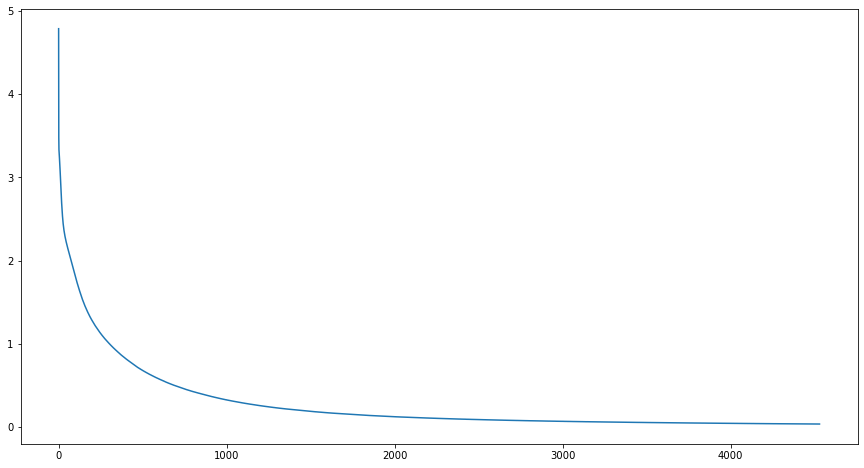

In [33]:
sk_mlp = MLPClassifier(
    hidden_layer_sizes=(50), 
    activation='relu', 
    solver='sgd',
    batch_size=32, 
    learning_rate="constant",
    shuffle=False,
    power_t=0,
    momentum=0.9,
    tol=0.000000001, 
    learning_rate_init=0.01, 
    validation_fraction=0,
    max_iter=4531,
    n_iter_no_change=9999999,
    alpha=0,
    nesterovs_momentum=False,
    verbose=False,
    random_state=None
)

sk_mlp.fit(X_train_scaled, y_train)

plt.figure(figsize=(15,8))
plt.plot(sk_mlp.loss_curve_)


y_train_pred = sk_mlp.predict(X_train_scaled)
y_test_pred = sk_mlp.predict(X_test_scaled)
y_val_pred = sk_mlp.predict(X_val_scaled)

pd.concat([
    get_classification_metrics(y_train, y_train_pred, index='Training'),
    get_classification_metrics(y_test, y_test_pred, index='Test'),
    get_classification_metrics(y_val, y_val_pred, index='Validation')
])
